<a href="https://colab.research.google.com/github/saurabh0512/kaggle_competitions/blob/master/Taxi_Trip_Duration_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install kaggle
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import json
token = {"username":"sigmafactor","key":"41fab59f19122a724d4d978dbf1c0bd1"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c nyc-taxi-trip-duration 

train.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!pip install geopandas

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import geopandas as gpd
from shapely.geometry import Point

%matplotlib inline

In [0]:
data_train=pd.read_csv('train.zip',compression='zip')
data_test=pd.read_csv('test.zip',compression='zip')
# data_weather=pd.read_csv('../content/weather-data-in-new-york-city-2016.zip',compression='zip')

 Checking outliers for latitudes and longitudes

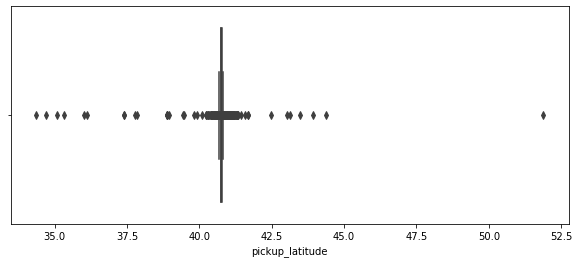

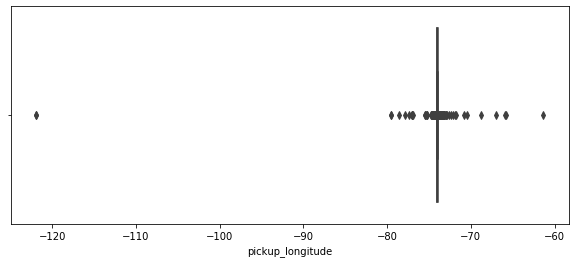

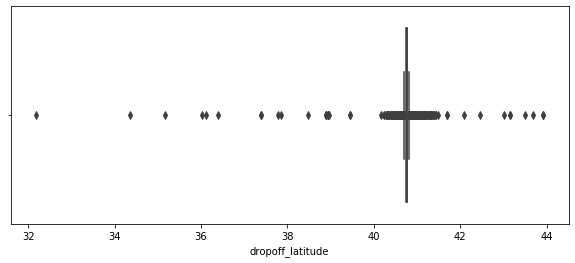

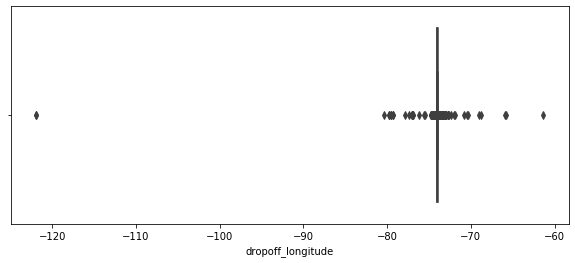

In [0]:
plt.figure(figsize=(10,4))
sns.boxplot(x=data_train['pickup_latitude'])

plt.figure(figsize=(10,4))
sns.boxplot(x=data_train['pickup_longitude'])

plt.figure(figsize=(10,4))
sns.boxplot(x=data_train['dropoff_latitude'])

plt.figure(figsize=(10,4))
sns.boxplot(x=data_train['dropoff_longitude'])

# Plot latitudes and longitudes

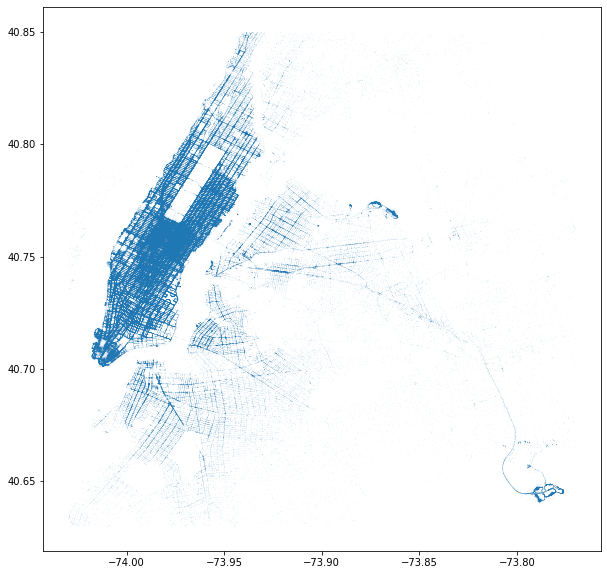

In [0]:
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
data_train = data_train[(data_train.pickup_longitude> xlim[0]) & (data_train.pickup_longitude < xlim[1])]
data_train = data_train[(data_train.dropoff_longitude> xlim[0]) & (data_train.dropoff_longitude < xlim[1])]
data_train = data_train[(data_train.pickup_latitude> ylim[0]) & (data_train.pickup_latitude < ylim[1])]
data_train = data_train[(data_train.dropoff_latitude> ylim[0]) & (data_train.dropoff_latitude < ylim[1])]

longitude = list(data_train.pickup_longitude) + list(data_train.dropoff_longitude)
latitude = list(data_train.pickup_latitude) + list(data_train.dropoff_latitude)
plt.figure(figsize = (10,10))
plt.plot(longitude,latitude,'.', alpha = 0.4, markersize = 0.05)
plt.show()


# Getting day,year,time from Datetime

In [0]:
def date_time_sort(data):
  data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'])
  data['Month']=data['pickup_datetime'].dt.month
  data['Day']=data['pickup_datetime'].dt.day
  data['hour']=data['pickup_datetime'].dt.hour
  data['day_of_week']=data['pickup_datetime'].dt.dayofweek
  return data

In [0]:
data_train.reset_index(inplace=True)
data_train.drop('index',axis=1,inplace=True)

# Converting coordinates into radians and finding distance using **Haversine** formula
(distance=sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2))

In [0]:
def get_distance(data):
  for j,feature in enumerate(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']):
    data[feature]=np.deg2rad(data[feature])
  
  from math import radians, cos, sin, asin, sqrt

  def haversine(lon1, lat1, lon2, lat2):
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

  data['distance']=[haversine(data['pickup_longitude'][i],data['pickup_latitude'][i],data['dropoff_longitude'][i],data['dropoff_latitude'][i]) for i in range(0,len(data))]
  data['distance']=data['distance'].round(2)
  return data

In [0]:
def transformations(data):
  data=date_time_sort(data)
  data=get_distance(data)
  return data

data_train=transformations(data_train)
data_test=transformations(data_test)

## Adding speed feature

In [0]:
data_train['speed']=(np.divide(data_train.distance,data_train.trip_duration))*3600

## Binning hours 

In [0]:
def get_timeslot(data):
  bins=(-1,5,8,18,24)
  labels=[1,2,3,4]
  categories=pd.cut(data.hour , bins , labels=labels)
  data['hour']=categories
  return data

In [0]:
data_train=get_timeslot(data_train)
data_test=get_timeslot(data_test)

## Using PCA to create feature which will contain rotated cordinates with rotated map

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
coords = np.vstack((data_train[['pickup_latitude', 'pickup_longitude']].values,
                    data_train[['dropoff_latitude', 'dropoff_longitude']].values,
                    data_test[['pickup_latitude', 'pickup_longitude']].values,
                    data_test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
data_train['pickup_pca0'] = pca.transform(data_train[['pickup_latitude', 'pickup_longitude']])[:, 0]
data_train['pickup_pca1'] = pca.transform(data_train[['pickup_latitude', 'pickup_longitude']])[:, 1]
data_train['dropoff_pca0'] = pca.transform(data_train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
data_train['dropoff_pca1'] = pca.transform(data_train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
data_test['pickup_pca0'] = pca.transform(data_test[['pickup_latitude', 'pickup_longitude']])[:, 0]
data_test['pickup_pca1'] = pca.transform(data_test[['pickup_latitude', 'pickup_longitude']])[:, 1]
data_test['dropoff_pca0'] = pca.transform(data_test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
data_test['dropoff_pca1'] = pca.transform(data_test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

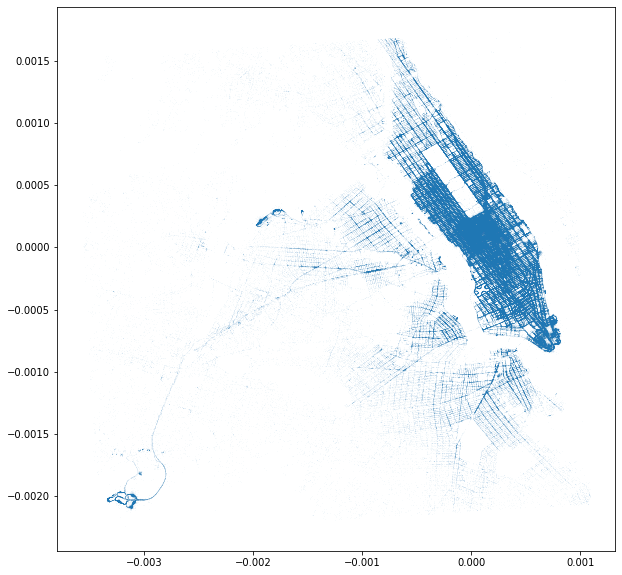

In [0]:
longitude = list(data_train.pickup_pca0) + list(data_train.dropoff_pca0)
latitude = list(data_train.pickup_pca1) + list(data_train.dropoff_pca1)
plt.figure(figsize = (10,10))
plt.plot(longitude,latitude,'.', alpha = 0.4, markersize = 0.05)
plt.show()

Final step data pre-processing

In [0]:
vendor_train=pd.get_dummies(data_train['vendor_id'],prefix='ven')
vendor_test=pd.get_dummies(data_test['vendor_id'],prefix='ven')
passenger_count_train=pd.get_dummies(data_train['passenger_count'],prefix='pass')
passenger_count_test=pd.get_dummies(data_test['passenger_count'],prefix='pass')
store_flag_train=pd.get_dummies(data_train['store_and_fwd_flag'],prefix='flag')
store_flag_test=pd.get_dummies(data_test['store_and_fwd_flag'],prefix='flag')
month_train=pd.get_dummies(data_train['Month'],prefix='mon')
month_test=pd.get_dummies(data_test['Month'],prefix='mon')
day_train=pd.get_dummies(data_train['Day'],prefix='day')
day_test=pd.get_dummies(data_test['Day'],prefix='day')
hour_train=pd.get_dummies(data_train['hour'],prefix='hour')
hour_test=pd.get_dummies(data_test['hour'],prefix='hour')
day_of_week_train=pd.get_dummies(data_train['day_of_week'],prefix='dow')
day_of_week_test=pd.get_dummies(data_test['day_of_week'],prefix='dow')

passenger_count_test=passenger_count_test.drop('pass_9',axis=1)

In [0]:
data_train_final=pd.concat([data_train,vendor_train,passenger_count_train,store_flag_train,month_train,day_train,hour_train,day_of_week_train],axis=1)
data_test_final=pd.concat([data_test,vendor_test,passenger_count_test,store_flag_test,month_test,day_test,hour_test,day_of_week_test],axis=1)

target=data_train_final.trip_duration
target=np.log(target.values+1)
data_train_final=data_train_final.drop('trip_duration',axis=1)

In [0]:
X_train,X_valid,y_train,y_valid=train_test_split(data_train_final,target,train_size=0.7,test_size=0.3,random_state=1)

X_valid=X_valid.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','Day','hour','day_of_week','speed','pickup_datetime','dropoff_datetime'],axis=1)
X_train=X_train.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','Day','hour','day_of_week','speed','pickup_datetime','dropoff_datetime'],axis=1)
data_test_final=data_test_final.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','Day','hour','day_of_week','pickup_datetime'],axis=1)

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics

In [0]:
# model=RandomForestRegressor(n_estimators=100,random_state=1)
# model.fit(X_train,y_train)
# prediction=model.predict(X_valid)
# print(np.sqrt(mean_squared_log_error(prediction,y_valid)))

Modelling with XGBoost

In [0]:
dtrain=xgb.DMatrix(data=X_train,label=y_train)
dvalid=xgb.DMatrix(data=X_valid,label=y_valid)
dtest=xgb.DMatrix(data_test_final)
param=dict(objective='reg:linear',eval_metric="rmse",max_depth=8,verbosity=1,min_child_weight=50,
           eta=0.1, as_pandas=True) 
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(param,dtrain,50,watchlist,early_stopping_rounds=10,verbose_eval=10)


[20:14:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:5.41209	valid-rmse:5.40939
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[10]	train-rmse:1.93522	valid-rmse:1.93353
[20]	train-rmse:0.793049	valid-rmse:0.792422
[30]	train-rmse:0.49341	valid-rmse:0.494562
[40]	train-rmse:0.437737	valid-rmse:0.440343
[49]	train-rmse:0.427305	valid-rmse:0.430779


In [0]:
xgb.plot_tree(model, num_trees=2)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

In [0]:
prediction_valid=model.predict(dvalid)
prediction_valid=np.exp(prediction_valid)-1

In [0]:
my_prediction=model.predict(dtest)
my_prediction=np.exp(my_prediction)-1

In [0]:
submission = pd.concat([data_test['id'], pd.DataFrame(my_prediction)], axis=1)
submission.columns = ['id','trip_duration']
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission.to_csv("submission.csv", index=False)

In [0]:
# !kaggle competitions submit -c nyc-taxi-trip-duration -f submission.csv -m "Message"